# Automatic translation with seq2seq + attention

This tutorial is available at https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

We use a sequence-to-sequence model, combining two recurrent neural networks: the encoder translates the input sequence into a vector, the decoder translates the vector back into the target language. In addition to this, a so-called attention mechanism makes it so the model learns to focus on a specific range of the input seq.

## The data
The data can be downloaded at: https://download.pytorch.org/tutorial/data.zip

It comes from https://tatoeba.org/ and in particular the file `data/eng-fra.txt` is a set of thousands of pairs of sentences (English-French).

First of all we need to represent each word in both languages with a one-hot vector. To do so, we first define a helper class of dictionaries to associate, for each language, each word to a unique index, and to keep track of how many occurrences of each word we encounter in the data.

In [2]:
# packages
#from io import open
import unicodedata
import string
import re
import random

In [3]:
# helper class Lang
SOS_token = 0 # manually set start-of-sentence and end-of-sentence tokens
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # count SOS and EOS

    def addWord(self, word): # function to add a word to the dictionaries
        if word not in self.word2index:
            self.word2index[word] = self.n_words # index is progressive with the order in which words are found
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1 # if the word was already in the dict, simply increase counter
        
    def addSentence(self, sentence): # function to add a sentence to the dictionary
        for word in sentence.split(' '):
            self.addWord(word)

For example:

In [4]:
# create Lang object
test = Lang("test")

# add sentence
test.addSentence("colorless green ideas")

In [5]:
# inspect dictionary
test.word2index

{'colorless': 2, 'green': 3, 'ideas': 4}

In [6]:
# add another sentence
test.addSentence("the quick brown fox")

# inspect dictionary
test.word2index

{'brown': 7,
 'colorless': 2,
 'fox': 8,
 'green': 3,
 'ideas': 4,
 'quick': 6,
 'the': 5}

In [7]:
# add another sentence
test.addSentence("the ideas of a green fox")

# inspect dictionary
test.word2index

{'a': 10,
 'brown': 7,
 'colorless': 2,
 'fox': 8,
 'green': 3,
 'ideas': 4,
 'of': 9,
 'quick': 6,
 'the': 5}

In [8]:
# counts
test.word2count

{'a': 1,
 'brown': 1,
 'colorless': 1,
 'fox': 2,
 'green': 2,
 'ideas': 2,
 'of': 1,
 'quick': 1,
 'the': 2}

Next, we simplify the data a bit turning it into ASCII (from Unicode), lowercasing and stripping (most) punctuation.

In [9]:
# turn a Unicode string to plain ASCII (see https://stackoverflow.com/a/518232/2809427)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# normalization
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip()) # to ASCII and lowercased
    s = re.sub(r"([.!?])", r" \1", s) # add space before <.>, <!> and <?>
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # remove non-letter characters except <.>, <!> and <?>
    return s

For example:

In [10]:
normalizeString("HeLlO! 3 people?")

'hello ! people ?'

Next, we read the data: we split the input files into lines, then each line into pairs.

In [11]:
def readLangs(lang1, lang2, reverse=False): # add a reverse option, see below
    print("Reading lines...")

    # read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # reverse pairs (if needed) then build Lang instances (we'll populate them later)
    if reverse: # the data is eng --> other_lang; if we want reverse translation we can set the flag to true
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    print("Done!")

    return input_lang, output_lang, pairs

For example:

In [12]:
eng, fra, pairs = readLangs("eng", "fra")

Reading lines...
Done!


In [13]:
# inspect the pairs
pairs[0:10]

[['go .', 'va !'],
 ['run !', 'cours !'],
 ['run !', 'courez !'],
 ['wow !', 'ca alors !'],
 ['fire !', 'au feu !'],
 ['help !', 'a l aide !'],
 ['jump .', 'saute .'],
 ['stop !', 'ca suffit !'],
 ['stop !', 'stop !'],
 ['stop !', 'arrete toi !']]

In [14]:
# how many pairs?
print(len(pairs))

135842


In order to be able to train and evaluate (and play with) a model quickly, we artificially reduce the data set in order to have only sentences which begin with the forms "I am", "you are" and similar; moreover, we set a maximum length to the sentences (say, 10 tokens).

In [15]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ", # these variants account for the apostrophes removed above
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p): # returns a boolean according to three conditions to be met
    return len(p[0].split(' ')) < MAX_LENGTH and \
    len(p[1].split(' ')) < MAX_LENGTH and \
    p[0].startswith(eng_prefixes)

def filterPairs(pairs): # filter based on boolean above
    return [pair for pair in pairs if filterPair(pair)]

For example:

In [16]:
# how many pairs "survive"?
len(filterPairs(pairs))

10599

In [17]:
# take a look
filterPairs(pairs)[0:10]

[['i m .', 'j ai ans .'],
 ['i m ok .', 'je vais bien .'],
 ['i m ok .', 'ca va .'],
 ['i m fat .', 'je suis gras .'],
 ['i m fat .', 'je suis gros .'],
 ['i m fit .', 'je suis en forme .'],
 ['i m hit !', 'je suis touche !'],
 ['i m hit !', 'je suis touchee !'],
 ['i m ill .', 'je suis malade .'],
 ['i m sad .', 'je suis triste .']]

Finally, we can bring everything together in a function:

In [18]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs: # add sentences to the dictionaries
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

For example:

In [19]:
input_lang, output_lang, pairs = prepareData('eng', 'fra')
print(random.choice(pairs))

Reading lines...
Done!
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345
['we re safe now .', 'nous sommes desormais en securite .']


Great! We can now move to...

## The model

### Encoding the input
It's simple enough RNN which yields a value for each word of the input sequence; in particular the output is a vector and a hidden state, which is used in the computation of the following word.

![encoder](https://pytorch.org/tutorials/_images/decoder-network.png)
(credits: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

In [20]:
# libraries
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) # embedding layer
        self.gru = nn.GRU(hidden_size, hidden_size) # GRU as recurrent layer

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Decoding with attention
Attention is nothing but a vector of weights: at each step, the decoder focuses on different parts of its input with different weights. These weights are of course learned during training using the input sentence. The weights are multiplied to the encoder's output then fed into a recurrent nn for decoding. At each step of the decoding, the output is a translated word and an hidden state, which is used as input for the decoding of the next word (together with the word's encoding and attention weights).

![decoder](https://pytorch.org/tutorials/_images/attention-decoder-network.png)
(credits: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

The code:

In [22]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1) # embeddings
        embedded = self.dropout(embedded) # dropout

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), # bmm is matrix multiplication
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

First, we define three helper functions to preprocess the data:

In [22]:
# get list of indexes corresponding to the words in a sentence (given the lang vocab above)
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

For example:

In [23]:
indexesFromSentence(input_lang, "i feel pretty")

[2, 2206, 450]

In [24]:
# get tensor associated with a sentence:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence) # get indexes
    indexes.append(EOS_token) # appen EOS token
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) # convert indexes to tensor

For example:

In [25]:
tensorFromSentence(input_lang, "i feel pretty")

tensor([[   2],
        [2206],
        [ 450],
        [   1]])

In [26]:
# convert input-outpu pair to tensors
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Finally, the training step is defined as follows:

In [27]:
teacher_forcing_ratio = 0.5 # higher values make the training faster at the expense of stability

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # teacher forcing: feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Two helper functions to keep track of elapsed time and estimate remaining time:

In [28]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The training procedure iterates the training step as follows:

In [29]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Helper function to plot the results:

In [30]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Actual training:

4m 18s (- 38m 47s) (1000 10%) 4.1028
8m 54s (- 35m 39s) (2000 20%) 3.6131
13m 46s (- 32m 7s) (3000 30%) 3.3523
18m 39s (- 27m 59s) (4000 40%) 3.2108
23m 17s (- 23m 17s) (5000 50%) 3.0650
27m 48s (- 18m 32s) (6000 60%) 2.9850
32m 19s (- 13m 51s) (7000 70%) 2.8362
52m 38s (- 13m 9s) (8000 80%) 2.7693
55m 17s (- 6m 8s) (9000 90%) 2.7223
57m 48s (- 0m 0s) (10000 100%) 2.6417


<Figure size 432x288 with 0 Axes>

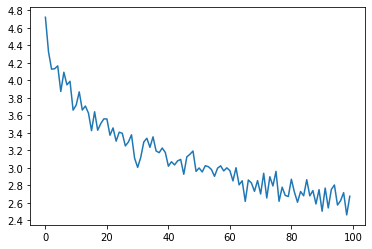

In [31]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=1000)

Finally, define an evaluation procedure to take a look at our model:

In [32]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

This is used in the following functions, which picks a few examples at random and translate them:

In [33]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

For example:

In [34]:
evaluateRandomly(encoder1, attn_decoder1)

> we re not going .
= nous n y allons pas .
< nous n y y <EOS>

> you re not dressed .
= tu n es pas habille .
< vous n etes pas <EOS>

> we re not happy .
= nous ne sommes pas contents .
< nous ne sommes pas . <EOS>

> he s a lovely young man .
= c est un jeune homme adorable .
< c est un homme homme . <EOS>

> he is generous to his friends .
= il est genereux envers ses amis .
< il est de de de . . <EOS>

> you re pathetic .
= vous etes pathetiques .
< vous etes fort . <EOS>

> i m really flattered to hear that .
= je suis tres flatte d entendre cela .
< je suis tres d etre . <EOS>

> we re almost ready .
= nous sommes presque pretes .
< nous sommes sommes en train de <EOS>

> i am glad to help you .
= je suis contente de vous aider .
< je suis de de te voir . <EOS>

> he is working in the field of biology .
= il travaille dans le domaine de la biologie .
< il est la la de . . <EOS>



Visualization of attention:

In [35]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

For example:

input = i m not perfect .
output = je ne suis pas <EOS>


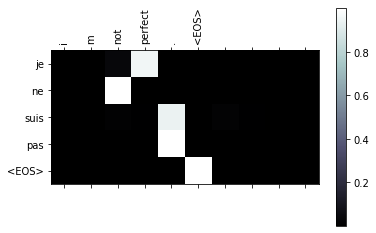

In [36]:
evaluateAndShowAttention("i m not perfect .")

input = i m surprised to see you here .
output = je suis rejouis de te voir ici . <EOS>


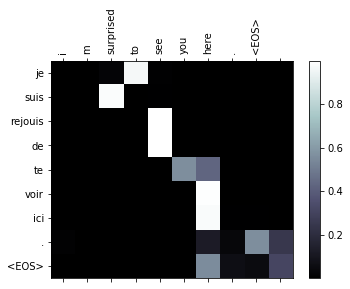

In [37]:
evaluateAndShowAttention("i m surprised to see you here .")